# Solar Power Forecasting

#### ETM 58D Business Analytics Project
* Uğurhan Aksu
* Burçak Aysen Kalmuk

## Table of Content

1. Introduction
2. Data Preparetion
3. Polynomial Regression Application to Complete Time Serie
4. Polynomial Regression Application to Production Hours Only
5. Application with Lagged Variables
6. Conclusion


## 1. Introduction

#### Problem description
In this project, it is aimed to make an hourly solar energy forecast for the next day with KIVANC 2 SPP (Solar Power Plant). KIVANÇ 2 SPP is located in Mersin (between 36-37° north latitude and 33-35° east longitude) and detailed information about capacity and location can be found at www.kivanç.com.tr.

#### Assumption and approach
The forecast can be used in real life needs of energy traders operating in energy markets. The assumption in this project is that on day d, forecasts are needed for day d+1 and you know the production values by the end of day d-1. In real life, forecasts for the next day (i.e. d+1) should be sent before 12:00 on day d.

Within the scope of the said scenario, it was tried to estimate the hourly solar production for the period between 1 March and 7 May 2022 by using different regression methods. Applied regression models ... The relationship between these different regression methods was examined.

#### Descriptive analysis of the given data
Provided dataset for the prediction includes the weather measurements for 9 grid points (coordinates) nearby the power plant. The weather variables that can help for solar power plant production forecasting are TEMP (Temperature at the provided location), REL_HUMIDITY (Relative humidity at the provided location), DSWRF (The short version of downward shortwave radiation flux), CLOUD_LOW_LAYER (Total cloud cover data in terms of percentage for low-level type of clouds). When checked, it was observed that there were no missing values in the date and hours data.


In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn import linear_model
import time

plt.rcParams['figure.figsize'] = [18, 10]
plt.rcParams['lines.linewidth'] = 1

## 2. Data Preparation

### Weather Dataset

#### Checking missing values
It was important to know if any date or hour is missing. Because project itself requires to have everyday input to predict the next day. It was observed that there was no missing data in date and time values.

In [3]:
weather = pd.read_csv( os.path.realpath("")+"/project_data/long_weather.csv" )

missing = 0
dates = pd.to_datetime( weather.date.unique(), format="%Y-%m-%d" )

for i in range( len(dates)-1 ):
    if dates[i+1] != ( dates[i] + pd.DateOffset( days=1 ) ):
        print("Missing dates between ", dates[i], "and", dates[i+1] )
        missing = 1
if missing == 0:
    print("There are not any missing date data points")
del dates

for i in range( weather.shape[0] ):
    if weather["hour"][i] != ((weather["hour"][0] + i) % 24):
        print("Missing hours between ", weather["hour"][i], "and", weather["hour"][i+1] )
if missing == 0:
    print("There are not any missing hour data points")    
del missing

weather.head()

There are not any missing date data points
There are not any missing hour data points


,date,hour,lat,lon,variable,value
0,2021-02-01,0,36.25,33.0,DSWRF,0.0
1,2021-02-01,1,36.25,33.0,DSWRF,0.0
2,2021-02-01,2,36.25,33.0,DSWRF,0.0
3,2021-02-01,3,36.25,33.0,DSWRF,0.0
4,2021-02-01,4,36.25,33.0,DSWRF,0.0


It is intended to group the dataset by date and time. For this, the date and time data had to be stabilized. For example, the "hour" values were corrected from 1, 2, 3 to 01, 02, 03. Thus, there would be no slippage when sorting by date.

In [4]:
weather["hour"] = weather["hour"].astype(str)
weather.dtypes

date         object
hour         object
lat         float64
lon         float64
variable     object
value       float64
dtype: object

In [5]:
def lenStabilizer( num ):
    if len( str(num) )  < 2:
        num = "0"+str(num)
    return num
weather["hour"] = weather["hour"].apply( lenStabilizer )

#### Merging date and hour

Date and hour data were coming as 2 separate values in the dataset. In order to be able to work with date data more easily, it was first formatted as year-month-day and time data was added next to it. Thus, the "time" data we obtained, as an example looked like this "2021-02-01 00:00:00".

In [6]:
def dateTimeFormatter( df ):
    #inefficient but works
    dates = []
    group = df.groupby( ["date", "hour"] ).mean().index.values
    for i in range( len(df.groupby( ["date", "hour"] ).mean().index.values) ):
        dates.append( pd.to_datetime(group[i][0] +"-"+ str(group[i][1]),format="%Y-%m-%d-%H") ) 
    
    return dates

def aggregate_weatherData( df, key='variable' ):
    weather = pd.DataFrame()
    for var in df[key].unique():
        weather[ var ] = df[ df.variable == var ].groupby( ["date","hour"] ).mean().value.values

    weather["TIME"] = dateTimeFormatter( df )
    
    #column re-order
    weather = weather[[weather.columns.values[-1]] + list(weather.columns.values[:-1])]
    
    return weather

weather = aggregate_weatherData( weather )
weather.head()

,TIME,DSWRF,REL_HUMIDITY,CLOUD_LOW_LAYER,TEMP
0,2021-02-01 00:00:00,0.0,88.877778,28.888889,277.898889
1,2021-02-01 01:00:00,0.0,87.255556,33.111111,277.844444
2,2021-02-01 02:00:00,0.0,85.566667,34.888889,277.741333
3,2021-02-01 03:00:00,0.0,84.577778,39.222222,277.881667
4,2021-02-01 04:00:00,0.0,85.322222,49.888889,277.774222


### Production Dataset

#### Checking missing values

Here also date data is formatted as previous dataset. Then, missing production values were checked and deficiencies were observed in some date ranges. However, there was no missing data in the date values.

In [7]:
prod = pd.read_csv( os.path.realpath("")+"/project_data/production.csv" )
max_prod = max(prod["production"])
prod.head()

,date,hour,production
0,2021-02-01,0,0.0
1,2021-02-01,1,0.0
2,2021-02-01,2,0.0
3,2021-02-01,3,0.0
4,2021-02-01,4,0.0


In [8]:
missing = 0
dates = pd.to_datetime( prod.date.unique(), format="%Y-%m-%d" )
for i in range( len(dates)-1 ):
    if dates[i+1] != ( dates[i] + pd.DateOffset( days=1 ) ):
        print("Missing dates between ", dates[i], "and", dates[i+1] )
        missing = 1
if missing == 0:
    print("There are not any missing date data points")
else:
    missing = 0
del dates

for i in range( prod.shape[0] ):
    if prod["hour"][i] != ((prod["hour"][0] + i) % 24):
        print("Missing hours between ", prod["hour"][i], "and", prod["hour"][i+1] )
        missing = 0
if missing == 0:
    print("There are not any hour data points missing")

Missing dates between  2021-02-19 00:00:00 and 2021-02-21 00:00:00
Missing dates between  2021-08-08 00:00:00 and 2021-08-12 00:00:00
Missing dates between  2022-01-12 00:00:00 and 2022-01-15 00:00:00
There are not any hour data points missing


Here again hours data values are stabilized as 01, 02, 03. And Then merged with formatted date values.

In [9]:
prod["hour"] = prod["hour"].astype(str)
prod.dtypes

date           object
hour           object
production    float64
dtype: object

In [10]:
prod["hour"] = prod["hour"].apply( lenStabilizer )
prod.head()

,date,hour,production
0,2021-02-01,00,0.0
1,2021-02-01,01,0.0
2,2021-02-01,02,0.0
3,2021-02-01,03,0.0
4,2021-02-01,04,0.0


In [11]:
prod["TIME"] = dateTimeFormatter( prod )
prod["VOLUME"] = prod["production"]
prod = prod[ ["TIME", "VOLUME"] ]
prod.head()

,TIME,VOLUME
0,2021-02-01 00:00:00,0.0
1,2021-02-01 01:00:00,0.0
2,2021-02-01 02:00:00,0.0
3,2021-02-01 03:00:00,0.0
4,2021-02-01 04:00:00,0.0


Production and Weather datasets are merged after the preperations are done.

In [12]:
data = prod.merge( weather, on="TIME", how="left" )
data.head()

,TIME,VOLUME,DSWRF,REL_HUMIDITY,CLOUD_LOW_LAYER,TEMP
0,2021-02-01 00:00:00,0.0,0.0,88.877778,28.888889,277.898889
1,2021-02-01 01:00:00,0.0,0.0,87.255556,33.111111,277.844444
2,2021-02-01 02:00:00,0.0,0.0,85.566667,34.888889,277.741333
3,2021-02-01 03:00:00,0.0,0.0,84.577778,39.222222,277.881667
4,2021-02-01 04:00:00,0.0,0.0,85.322222,49.888889,277.774222


In [13]:
data.describe()

,VOLUME,DSWRF,REL_HUMIDITY,CLOUD_LOW_LAYER,TEMP
count,10896.000000,10896.000000,10896.000000,10896.000000,10896.000000
mean,10.443383,235.922696,52.421451,14.210702,286.281420
std,14.255581,286.462111,20.572918,26.212781,9.084364
min,0.000000,0.000000,12.666667,0.000000,264.606556
25%,0.000000,0.000000,35.744444,0.000000,279.230889
50%,0.249500,74.031111,50.294444,0.188889,285.844056
75%,21.954500,451.322778,67.122222,15.136111,293.375639
max,39.880000,929.281778,99.611111,100.000000,308.902111


After merging produciont and weather datasets missing values are checked and observed that they are still the same missing rows which indicates that while merging there was no problem.

In [14]:
for i in range( data.shape[0]-1 ):
    if data["TIME"][i+1] != ( data["TIME"][i] + pd.DateOffset( hours=1 ) ):
        print("Missing hours between ", data["TIME"][i], "and", data["TIME"][i+1] )

Missing hours between  2021-02-19 23:00:00 and 2021-02-21 00:00:00
Missing hours between  2021-08-08 23:00:00 and 2021-08-12 00:00:00
Missing hours between  2022-01-12 23:00:00 and 2022-01-15 00:00:00


Now, the existence of all values in the data of a date, that is, in a row, has been checked and it has been examined that there are no null values.

In [15]:
sum(sum(np.isnan( data ).values))

0

Since the ranges of the values in the different columns in our dataset are different from each other, comparable lines will not appear on the graphs, so they are scaled to fit within the 0-1 range.

In [16]:
def listScaler( listt ):
    listt = (listt - min(listt))/( max(listt) - min(listt) )
    return listt

scaled_data = data.apply( listScaler )
scaled_data["TIME"] = data["TIME"]
scaled_data.head()

,TIME,VOLUME,DSWRF,REL_HUMIDITY,CLOUD_LOW_LAYER,TEMP
0,2021-02-01 00:00:00,0.0,0.0,0.876550,0.288889,0.300083
1,2021-02-01 01:00:00,0.0,0.0,0.857891,0.331111,0.298854
2,2021-02-01 02:00:00,0.0,0.0,0.838466,0.348889,0.296526
3,2021-02-01 03:00:00,0.0,0.0,0.827093,0.392222,0.299694
4,2021-02-01 04:00:00,0.0,0.0,0.835655,0.498889,0.297268


Correlations of data were looked at to find a relationship between input and output. A relationship was found, but we thought it was not sufficient.

In [17]:
scaled_data[ scaled_data.columns.values[1::] ].corr()

,VOLUME,DSWRF,REL_HUMIDITY,CLOUD_LOW_LAYER,TEMP
VOLUME,1.000000,0.688906,-0.481226,-0.205853,0.431930
DSWRF,0.688906,1.000000,-0.547792,-0.189449,0.513565
REL_HUMIDITY,-0.481226,-0.547792,1.000000,0.640741,-0.715288
CLOUD_LOW_LAYER,-0.205853,-0.189449,0.640741,1.000000,-0.405409
TEMP,0.431930,0.513565,-0.715288,-0.405409,1.000000


Correlation was checked with nighttime data removed.

In [18]:
scaled_data[scaled_data["VOLUME"] != 0][ scaled_data.columns.values[1::] ].corr()

,VOLUME,DSWRF,REL_HUMIDITY,CLOUD_LOW_LAYER,TEMP
VOLUME,1.000000,0.492424,-0.492431,-0.350450,0.400582
DSWRF,0.492424,1.000000,-0.602194,-0.283071,0.523322
REL_HUMIDITY,-0.492431,-0.602194,1.000000,0.690273,-0.741003
CLOUD_LOW_LAYER,-0.350450,-0.283071,0.690273,1.000000,-0.459788
TEMP,0.400582,0.523322,-0.741003,-0.459788,1.000000


And finally, the correlation was checked by grouping by days and the most successful result was obtained here.

In [19]:
scaled_data.groupby([scaled_data['TIME'].dt.date]).mean().corr()

,VOLUME,DSWRF,REL_HUMIDITY,CLOUD_LOW_LAYER,TEMP
VOLUME,1.000000,0.775168,-0.741833,-0.636284,0.668846
DSWRF,0.775168,1.000000,-0.764626,-0.677397,0.673067
REL_HUMIDITY,-0.741833,-0.764626,1.000000,0.776811,-0.717573
CLOUD_LOW_LAYER,-0.636284,-0.677397,0.776811,1.000000,-0.510239
TEMP,0.668846,0.673067,-0.717573,-0.510239,1.000000


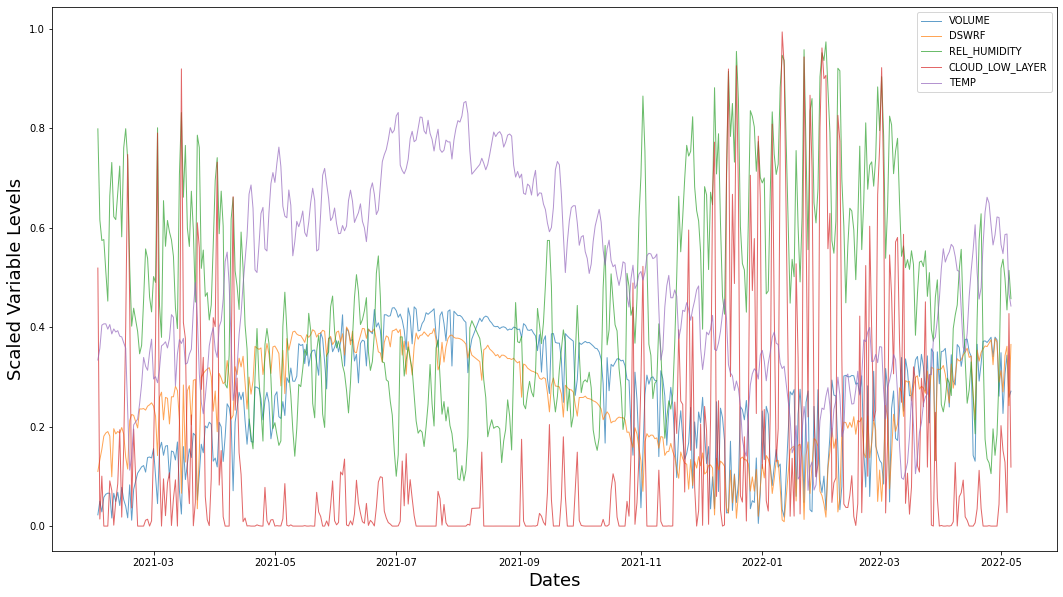

In [20]:
for col in scaled_data.groupby([scaled_data['TIME'].dt.date]).mean().columns.values:
    plt.plot(scaled_data.groupby([scaled_data['TIME'].dt.date]).mean().index.values,
             scaled_data.groupby([scaled_data['TIME'].dt.date]).mean()[col],
             label=col,
             alpha=0.7)
plt.legend()
plt.xlabel( "Dates", fontsize=18 )
plt.ylabel( "Scaled Variable Levels", fontsize=18 )
plt.show()

According to the interpretation that can be made on the graph, the relations are proportioned as follows:

* Production decreases with the rise of humidity and the increase of clouds.
* With the increase in temperature, production increases in parallel.
* DSWRF seems to have no effect on production.

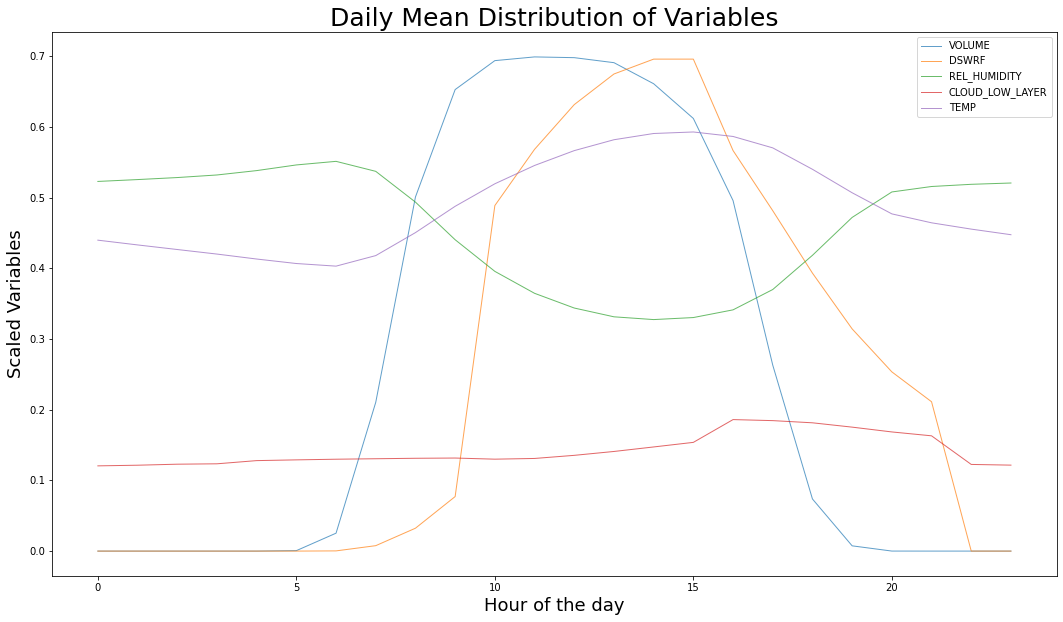

In [21]:
scaled_data.groupby([scaled_data['TIME'].dt.hour]).mean()

for col in scaled_data.groupby([scaled_data['TIME'].dt.hour]).mean().columns.values:
    plt.plot(scaled_data.groupby([scaled_data['TIME'].dt.hour]).mean().index.values,
             scaled_data.groupby([scaled_data['TIME'].dt.hour]).mean()[col],
             label=col,
             alpha=0.7)
plt.legend()
plt.xlabel( "Hour of the day", fontsize=18 )
plt.ylabel( "Scaled Variables", fontsize=18 )
plt.title( "Daily Mean Distribution of Variables", fontsize=25 )
plt.show()

The same graph was shown again with the mean values in the correlation table and a cleaner table was formed. The graphic comments mentioned above have reinforced itself. Only the simplified view of the cloud values does not allow us to make the same interpretation.


## 3. Polynomial Regression Application to Complete Time Serie

#### Train & Test

As part of this project, it was desired to predict for the day of March 1, so the index of March 1 is found which is 9240. Then the data before the index of March 1 is seperated as train data and the data after that index is seperated as test data.

In [22]:
#20220301 date location
test_loc = data[data["TIME"].dt.date == pd.to_datetime("20220301", format="%Y%m%d")].index.values[0] - 2*24
test_loc

/Users/burcakkalmuk/opt/anaconda3/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


9240

In [23]:
x_train = np.asanyarray( scaled_data[scaled_data.columns.values[2:]][:test_loc] )
y_train = np.asanyarray( scaled_data["VOLUME"][:test_loc] )
x_test = np.asanyarray( scaled_data[scaled_data.columns.values[2:]][test_loc:] )
y_test = np.asanyarray( scaled_data["VOLUME"][test_loc:] )

The model was trained using train data, with a maximum of 10th order. Afterwards, predictions were taken from each trained model. Each degree was compared with each other and with the mean squared error and R squared metrics.

In [24]:
#requires time
start = time.time()

#total error lists
mse_train = []
mse_test = []
rsq_train = []
rsq_test = []
n_list = []

#evaluation for different polinomial degrees
n_max=15
for n in range (1, n_max+1):
    poly = PolynomialFeatures(degree=n)
    x_train_p = poly.fit_transform(x_train)
    x_test_p = poly.fit_transform(x_test)
    
    lr = linear_model.LinearRegression()
    lr.fit( x_train_p, y_train )
    train_pred = lr.predict( x_train_p )
    test_pred = lr.predict( x_test_p )
    
    n_list.append( n )
    mse_train.append( metrics.mean_squared_error( y_train, train_pred ) )
    mse_test.append( metrics.mean_squared_error( y_test, test_pred ) )
    rsq_train.append( lr.score( poly.fit_transform(x_train) , y_train ) )
    rsq_test.append( lr.score( poly.fit_transform(x_test) , y_test ) )

print( "Elapsed time", round(time.time()-start,2), "seconds." )

#error dataframe 
n_dict = {
    "Degree" : n_list,
    "mse_train": mse_train,
    "mse_test": mse_test,
    "Rsq_train":rsq_train,
    "Rsq_test":rsq_train,
}
n_df = pd.DataFrame.from_dict(n_dict)

Elapsed time 43.86 seconds.


#### Polynomial Degrees

When the comparison chart with the Mean squared below is examined, it is seen that the error value increases after the 9th degree. For this reason, 9th degree and above should not be used in the solution of pollinoma.

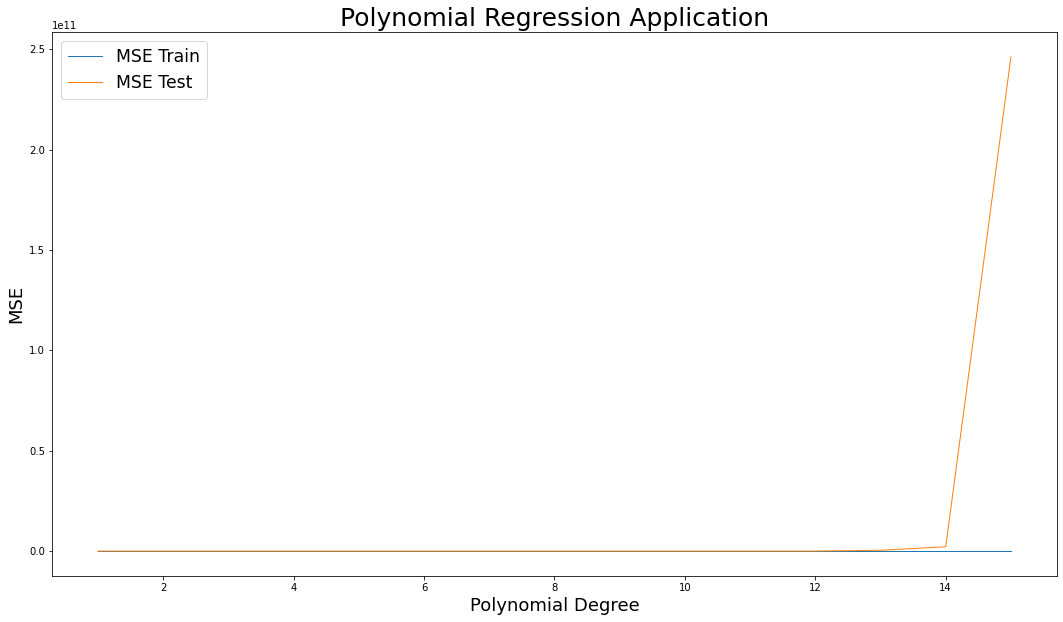

In [25]:
plt.plot(n_dict["Degree"], n_dict["mse_train"], label="MSE Train")
plt.plot(n_dict["Degree"], n_dict["mse_test"], label="MSE Test")
plt.legend(loc=2,fontsize="xx-large")
plt.xlabel("Polynomial Degree", fontsize=18)
plt.ylabel("MSE", fontsize=18)
plt.title( "Polynomial Regression Application", fontsize=25 )
plt.show()

When looked at the comparison graph below with R squared, the capacity of this model to explain the variance in the data increases, even at the 9th degree. In fact, this situation contradicts the information in the previous chart.

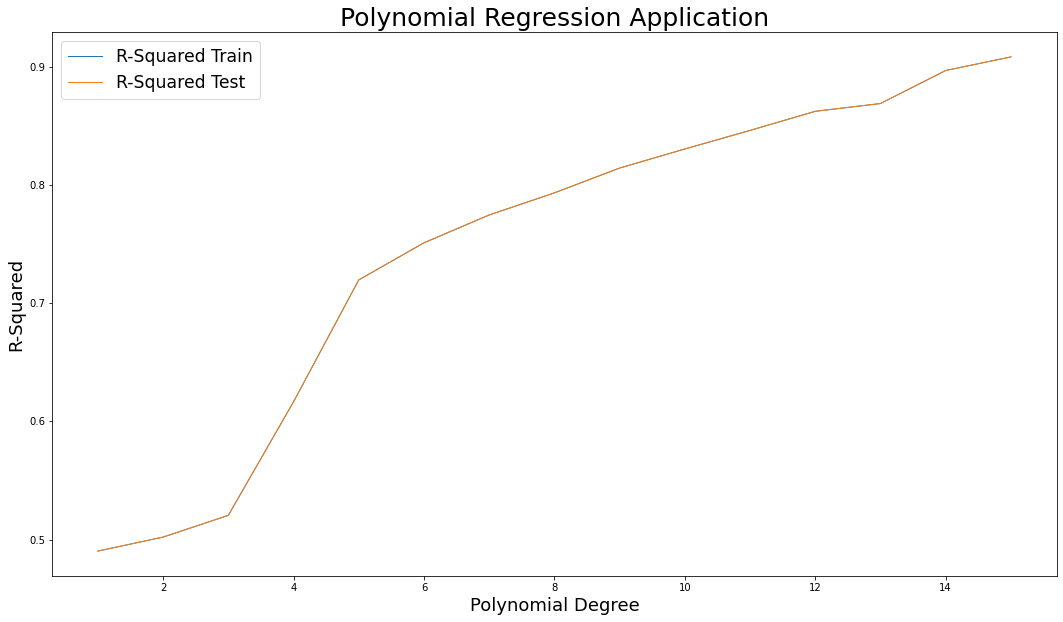

In [26]:
plt.plot(n_dict["Degree"], n_dict["Rsq_train"], label="R-Squared Train")
plt.plot(n_dict["Degree"], n_dict["Rsq_test"], label="R-Squared Test")
plt.legend(loc=2,fontsize="xx-large")
plt.xlabel("Polynomial Degree", fontsize=18)
plt.ylabel("R-Squared", fontsize=18)
plt.title( "Polynomial Regression Application", fontsize=25 )
plt.show()

When the graphs above were examined, it was concluded that the degree with the highest success rate was 8. Thus, the model was created with the 8th degree.

In [27]:
#requires time
start = time.time()

#model with best configuration
#n_best = n_df[ n_df["MSE"] == n_df["MSE"].min() ]["Degree"].values
n_best=14
print( "Best n: ", int(n_best) )
poly = PolynomialFeatures(degree=int(n_best))
x_train_p = poly.fit_transform(x_train)
lr = linear_model.LinearRegression()
lr.fit( x_train_p, y_train )
train_prediction = lr.predict( x_train_p )

#post processing
train_prediction[train_prediction < 0.01] = 0
train_prediction[train_prediction > 2] = 2

print( "Elapsed time", round(time.time()-start,2), "seconds." )

#regression params
print("Regression intercept: ", lr.intercept_)
#print("Regression coefficents: ", lr.coef_)
print("Reg score: ",lr.score( poly.fit_transform(x_train) , y_train ))

Best n:  14
Elapsed time 9.7 seconds.
Regression intercept:  1843912.1174929852
Reg score:  0.8967424653741799


#### Prediction
The first prediction results were obtained from the model. It seems very difficult to read in this state, but it can be understood that the model works according to the oscillation.

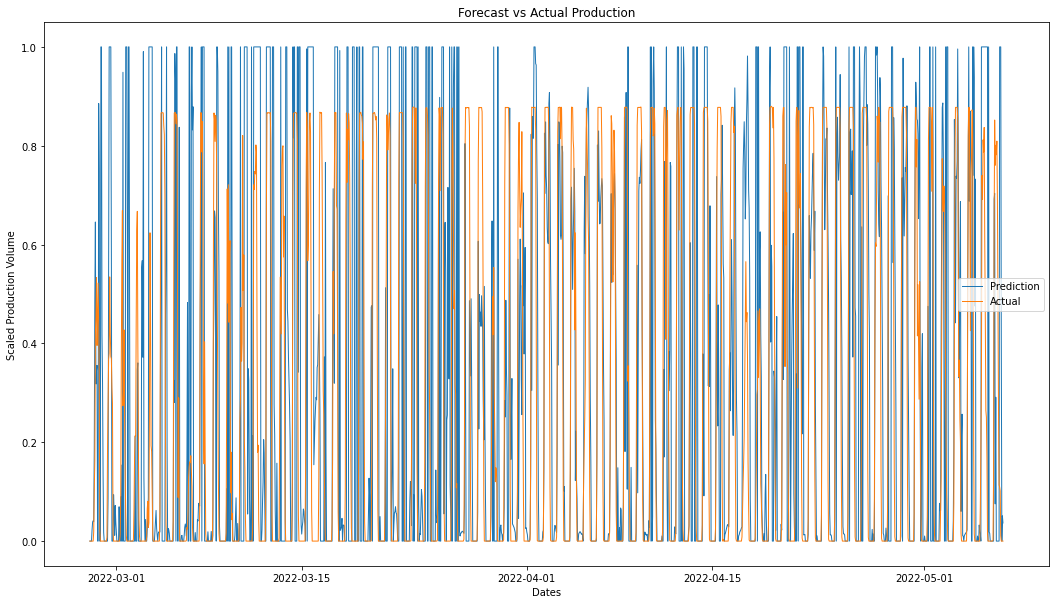

In [28]:
x_test_p = poly.fit_transform(x_test)
test_prediction = lr.predict( x_test_p )

#post processing
test_prediction[ test_prediction < 0.01 ] = 0
test_prediction[ test_prediction > 1 ] = 1

plt.plot(scaled_data["TIME"][test_loc:],
        test_prediction,
        label="Prediction")
plt.plot(scaled_data["TIME"][test_loc:],
        scaled_data["VOLUME"][test_loc:],
        label="Actual")

plt.xlabel( "Dates" )
plt.ylabel( "Scaled Production Volume" )
plt.title( "Forecast vs Actual Production" )
plt.legend()
plt.show()

In order to make the graph more readable, the model and forecast values were averaged over the same hours of different days.

No handles with labels found to put in legend.


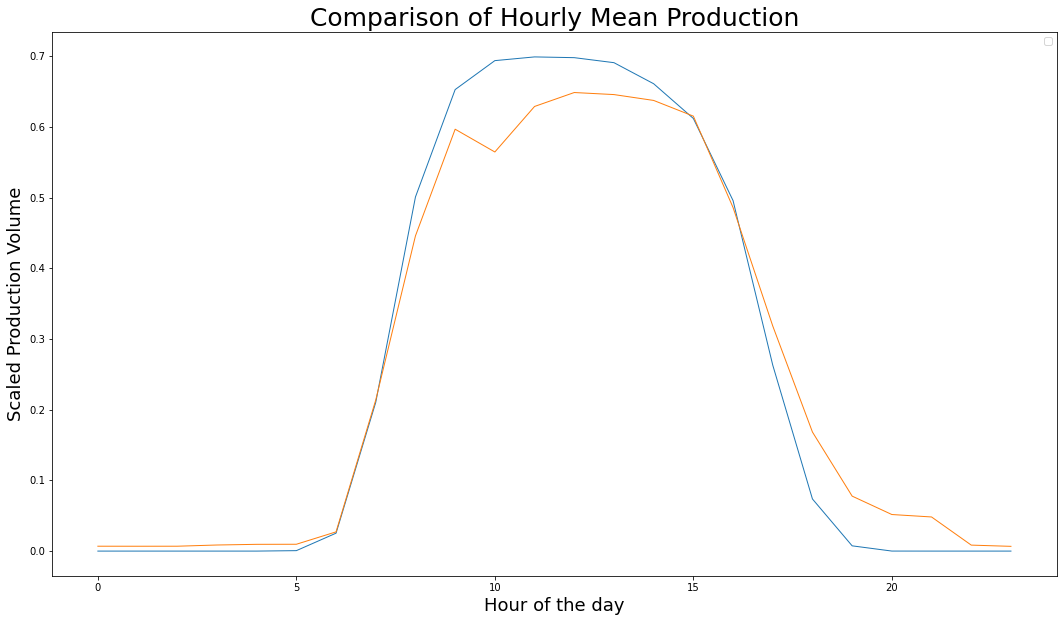

In [29]:
prediction_hourly_means = []
for i in range(0,24):
    prediction_hourly_means.append( np.mean( train_prediction[i:len(train_prediction):24] ) )

plt.plot(scaled_data.groupby([scaled_data['TIME'].dt.hour]).mean().index.values,
        scaled_data.groupby([scaled_data['TIME'].dt.hour]).mean()["VOLUME"])
plt.plot(scaled_data.groupby([scaled_data['TIME'].dt.hour]).mean().index.values,
        prediction_hourly_means)

plt.xlabel( "Hour of the day", fontsize=18 )
plt.ylabel( "Scaled Production Volume", fontsize=18 )
plt.title( "Comparison of Hourly Mean Production", fontsize=25 )
plt.legend()
plt.show()

What we see in the graphs above are the prediction made with the train data. The chart below shows the prediction made with the test data.

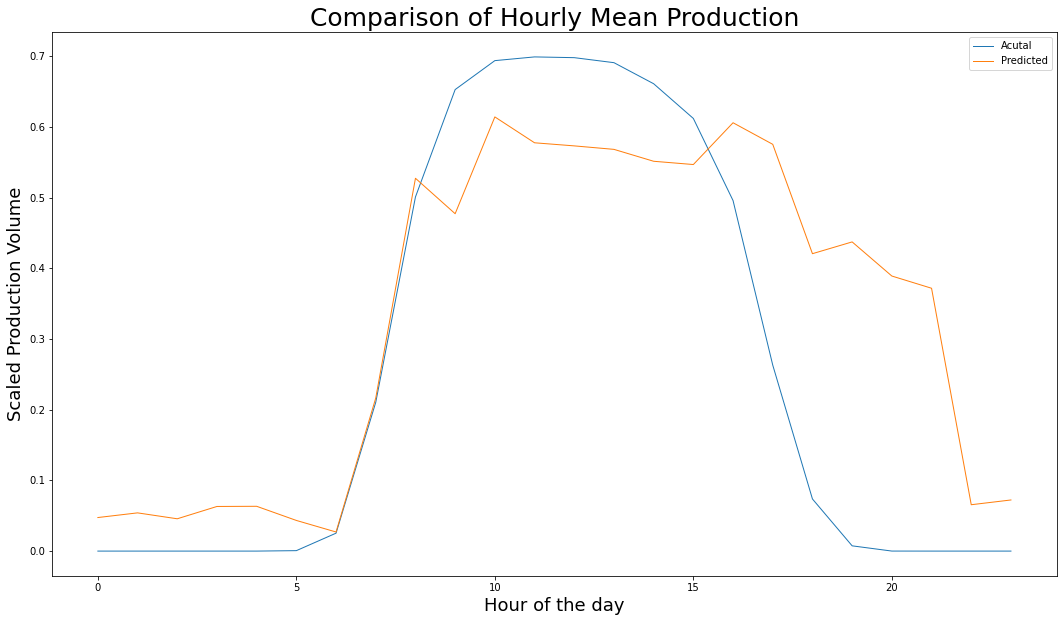

In [30]:
prediction_hourly_means = []
for i in range(0,24):
    prediction_hourly_means.append( np.mean( test_prediction[i:len(test_prediction):24] ) )

plt.plot(scaled_data.groupby([scaled_data['TIME'].dt.hour]).mean().index.values,
        scaled_data.groupby([scaled_data['TIME'].dt.hour]).mean()["VOLUME"],
        label="Acutal")
plt.plot(scaled_data.groupby([scaled_data['TIME'].dt.hour]).mean().index.values,
        prediction_hourly_means,
        label="Predicted")
plt.xlabel( "Hour of the day", fontsize=18 )
plt.ylabel( "Scaled Production Volume", fontsize=18 )
plt.title( "Comparison of Hourly Mean Production", fontsize=25 )
plt.legend()
plt.show()

## 4. Polynomial Regression Application to Production Hours Only

This time, it was aimed to set up a model and make predictions by removing the data where there was no production at night, as there was no sun at night from the dataset.

In the chart below, the hours of no production on an average day are shown as blue columns.

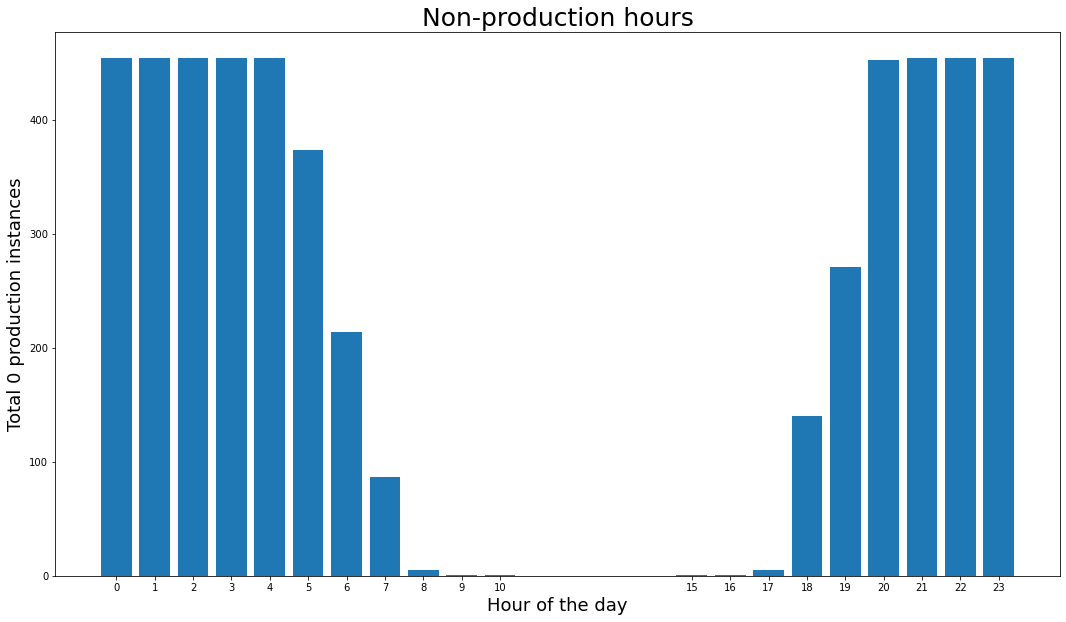

In [31]:
xticks = scaled_data[scaled_data["VOLUME"] == 0].groupby( [scaled_data["TIME"].dt.hour] ).count()["TIME"].index
plt.bar( xticks,
         scaled_data[scaled_data["VOLUME"] == 0].groupby( [scaled_data["TIME"].dt.hour] ).count()["TIME"].values)
plt.title("Non-production hours", fontsize=25)
plt.xticks( xticks )
plt.xlabel( "Hour of the day", fontsize=18 )
plt.ylabel( "Total 0 production instances", fontsize=18 )
plt.show()

In the summer, my daytime is longer than the winter season, so if we want to exclude the hours that are not produced for each day, it can turn into an irregular data. For this reason, the average hours of production were collected in an array, and then the non-production hours were filtered from the dataset.

In [32]:
#main production hours
prod_times = scaled_data[scaled_data["VOLUME"] == 0].groupby( [scaled_data["TIME"].dt.hour] ).count()["TIME"][scaled_data[scaled_data["VOLUME"] == 0].groupby( [scaled_data["TIME"].dt.hour] ).count()["TIME"] < 275].index.values
prod_times

array([ 6,  7,  8,  9, 10, 15, 16, 17, 18, 19])

In [32]:
prod_data = scaled_data[(scaled_data["TIME"].dt.hour > min( prod_times )) & (scaled_data["TIME"].dt.hour < max( prod_times ))]
prod_data.reset_index( drop=True, inplace=True )
prod_data

,TIME,VOLUME,DSWRF,REL_HUMIDITY,CLOUD_LOW_LAYER,TEMP
0,2021-02-01 07:00:00,0.000000,0.000000,0.835527,0.658889,0.310061
1,2021-02-01 08:00:00,0.004739,0.000000,0.853291,0.684444,0.308170
2,2021-02-01 09:00:00,0.033852,0.006935,0.843195,0.703333,0.331312
3,2021-02-01 10:00:00,0.043380,0.159024,0.791949,0.673333,0.356276
4,2021-02-01 11:00:00,0.068455,0.218807,0.770479,0.686667,0.371826
...,...,...,...,...,...,...
5443,2022-05-06 14:00:00,0.465898,0.953477,0.261342,0.116222,0.534453
5444,2022-05-06 15:00:00,0.256520,0.954821,0.269393,0.134444,0.537945
5445,2022-05-06 16:00:00,0.113591,0.800465,0.281406,0.268778,0.529634
5446,2022-05-06 17:00:00,0.109579,0.693783,0.313866,0.258333,0.513616


#### Train & Test
After that, it was divided into two parts as train and test, using the index of March 1 in the same way as is done previously.

In [33]:
#20220301 date location
test_loc = prod_data[prod_data["TIME"].dt.date == pd.to_datetime("20220301", format="%Y%m%d")].index.values[0] - 2*24

x_train = np.asanyarray( prod_data[prod_data.columns.values[2:]][:test_loc] )
y_train = np.asanyarray( prod_data["VOLUME"][:test_loc] )
x_test = np.asanyarray( prod_data[prod_data.columns.values[2:]][test_loc:] )
y_test = np.asanyarray( prod_data["VOLUME"][test_loc:] )

/Users/han/Anaconda/anaconda3/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [34]:
#requires much time
start = time.time()

#total error lists
mse_train = []
mse_test = []
rsq_train = []
rsq_test = []
n_list = []

#evaluation for different polinomial degrees
n_max=15
for n in range (1, n_max+1):
    poly = PolynomialFeatures(degree=n)
    x_train_p = poly.fit_transform(x_train)
    x_test_p = poly.fit_transform(x_test)
    
    lr = linear_model.LinearRegression()
    lr.fit( x_train_p, y_train )
    train_pred = lr.predict( x_train_p )
    test_pred = lr.predict( x_test_p )
    
    n_list.append( n )
    mse_train.append( metrics.mean_squared_error( y_train, train_pred ) )
    mse_test.append( metrics.mean_squared_error( y_test, test_pred ) )
    rsq_train.append( lr.score( poly.fit_transform(x_train) , y_train ) )
    rsq_test.append( lr.score( poly.fit_transform(x_test) , y_test ) )

print( "Elapsed time", round(time.time()-start,2), "seconds." )

#error dataframe 
n_dict = {
    "Degree" : n_list,
    "mse_train": mse_train,
    "mse_test": mse_test,
    "Rsq_train":rsq_train,
    "Rsq_test":rsq_train,
}
n_df = pd.DataFrame.from_dict(n_dict)

Elapsed time 47.12 seconds.


#### Polynomial Degrees
As can be seen in the graphic below, the error value increases from the 14th degree. For this reason, 14th degree and above should not be used.

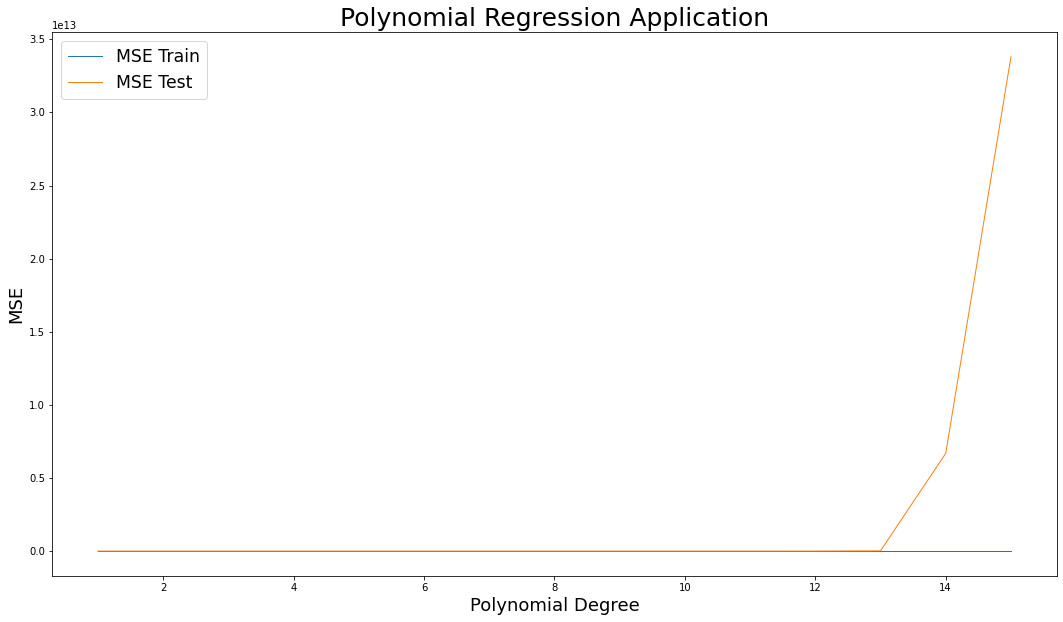

In [35]:
plt.plot(n_dict["Degree"], n_dict["mse_train"], label="MSE Train")
plt.plot(n_dict["Degree"], n_dict["mse_test"], label="MSE Test")
plt.legend(loc=2,fontsize="xx-large")
plt.xlabel("Polynomial Degree", fontsize=18)
plt.ylabel("MSE", fontsize=18)
plt.title( "Polynomial Regression Application", fontsize=25 )
plt.show()

When we look at the comparison chart with the R square below, the capacity of this model to explain the variance in the data drops significantly at the 14th degree and beyond. In this case, the 13th degree was chosen.

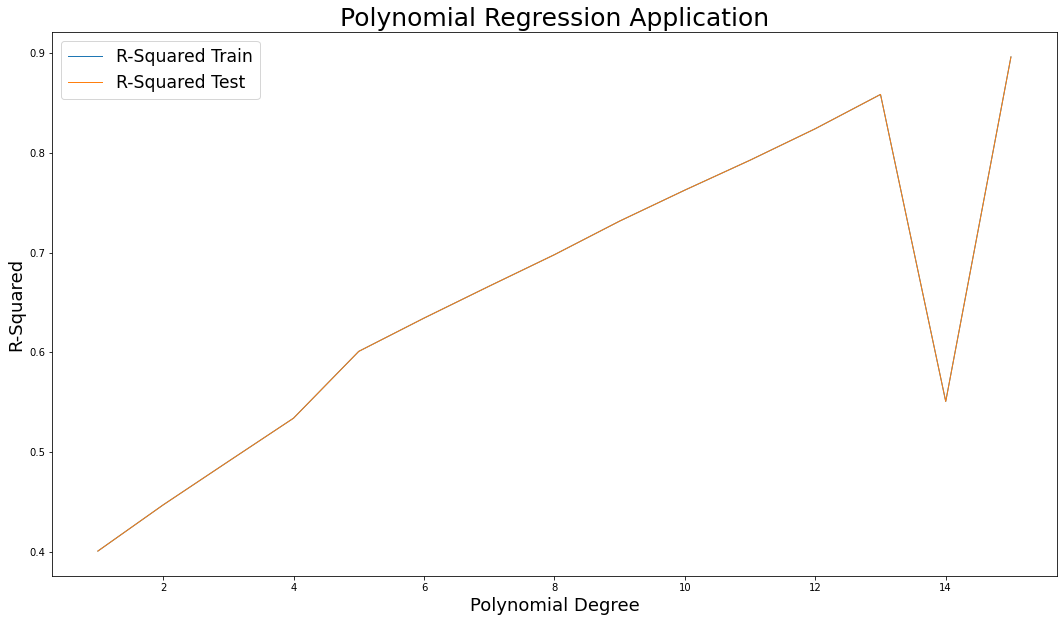

In [36]:
plt.plot(n_dict["Degree"], n_dict["Rsq_train"], label="R-Squared Train")
plt.plot(n_dict["Degree"], n_dict["Rsq_test"], label="R-Squared Test")
plt.legend(loc=2,fontsize="xx-large")
plt.xlabel("Polynomial Degree", fontsize=18)
plt.ylabel("R-Squared", fontsize=18)
plt.title( "Polynomial Regression Application", fontsize=25 )
plt.show()

#### Prediction
Predictions are as in the graph below when 13th-degree polynomial is used. It is seen that the model does not give very accurate predictions when the data of night hours where there is no production are not considered in the model. In this case, we can say that it is beneficial to use night hours data as well.

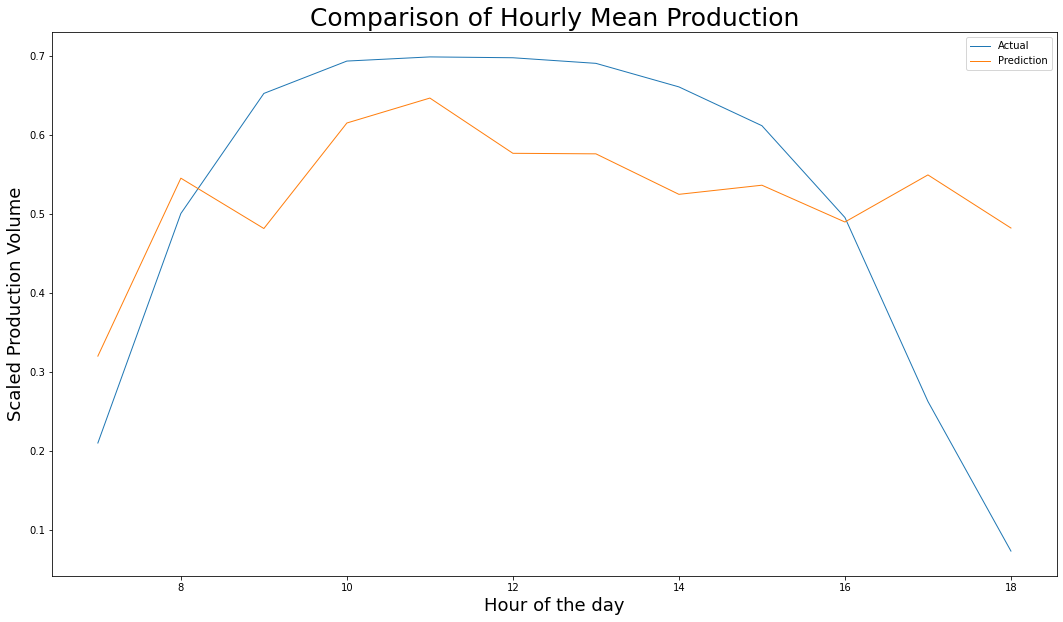

In [37]:
poly = PolynomialFeatures(degree=13)
x_train_p = poly.fit_transform(x_train)
x_test_p = poly.fit_transform(x_test)
    
lr = linear_model.LinearRegression()
lr.fit( x_train_p, y_train )
    
test_prediction = lr.predict( x_test_p )

#post processing
test_prediction[ test_prediction < 0.01 ] = 0
test_prediction[ test_prediction > 1 ] = 1
prediction_hourly_means = []
for i in range(0,len( prod_data.groupby([prod_data['TIME'].dt.hour]).mean().index.values )):
    prediction_hourly_means.append( np.mean( test_prediction[i:len(test_prediction):len(prod_times)+2] ) )

plt.plot(prod_data.groupby([prod_data['TIME'].dt.hour]).mean().index.values,
        prod_data.groupby([prod_data['TIME'].dt.hour]).mean()["VOLUME"],
        label="Actual")
plt.plot(prod_data.groupby([prod_data['TIME'].dt.hour]).mean().index.values,
        prediction_hourly_means,
        label="Prediction")

plt.xlabel( "Hour of the day", fontsize=18 )
plt.ylabel( "Scaled Production Volume", fontsize=18 )
plt.title( "Comparison of Hourly Mean Production", fontsize=25 )
plt.legend()
plt.show()

## 5. Application with Lagged Variables

Application with lagged variables did not give a generally usable prediction. Infeasible because it is computationally intensive. It took 3 seconds to build a 4th degree model and +120 seconds to build a 5th degree model. In addition, it was seen that 1 hour was not enough to create a model from the 8th degree. Due to the long time required, the use of this method was abandoned. Estimates at other degrees were found insufficient as they were far from the truth.

In [38]:
VOLUME_mean = np.zeros(data.shape[0])
VOLUME_std = np.zeros(data.shape[0])
DSWRF_mean = np.zeros(data.shape[0])
DSWRF_std = np.zeros(data.shape[0])
REL_HUMIDITY_mean = np.zeros(data.shape[0])
REL_HUMIDITY_std = np.zeros(data.shape[0])
CLOUD_LOW_LAYER_mean = np.zeros(data.shape[0])
CLOUD_LOW_LAYER_std = np.zeros(data.shape[0])
TEMP_mean = np.zeros(data.shape[0])
TEMP_std = np.zeros(data.shape[0])
for day in data["TIME"].dt.date.unique():
    for key in data.columns.values[2:]:
        eval_mean_str = ( key+"_mean[ data[ data['TIME'].dt.date == day ].index.values ] = np.mean(weather[weather['TIME'].dt.date == day][key])" )
        eval_std_str = ( key+"_std[ data[ data['TIME'].dt.date == day ].index.values ] = np.std(weather[weather['TIME'].dt.date == day][key])" )        
        exec(eval_mean_str)
        exec(eval_std_str)
        #np.mean(weather[weather["TIME"].dt.date == day][key])
        #np.std(weather[weather["TIME"].dt.date == day][key])

    
l_dict = {
    "TIME" : data["TIME"],
    "DSWRF_mean": DSWRF_mean,
    "DSWRF_std":DSWRF_std,
    "REL_HUMIDITY_mean":REL_HUMIDITY_mean,
    "REL_HUMIDITY_std" : REL_HUMIDITY_std,
    "CLOUD_LOW_LAYER_mean": CLOUD_LOW_LAYER_mean,
    "CLOUD_LOW_LAYER_std": CLOUD_LOW_LAYER_std,
    "TEMP_mean":TEMP_mean,
    "TEMP_std":TEMP_std,
}

lagged = pd.DataFrame.from_dict(l_dict)
lagged.head(5)

    

,TIME,DSWRF_mean,DSWRF_std,REL_HUMIDITY_mean,REL_HUMIDITY_std,CLOUD_LOW_LAYER_mean,CLOUD_LOW_LAYER_std,TEMP_mean,TEMP_std
0,2021-02-01 00:00:00,102.074074,112.622364,82.093056,4.780804,51.865741,20.080598,279.394477,1.712119
1,2021-02-01 01:00:00,102.074074,112.622364,82.093056,4.780804,51.865741,20.080598,279.394477,1.712119
2,2021-02-01 02:00:00,102.074074,112.622364,82.093056,4.780804,51.865741,20.080598,279.394477,1.712119
3,2021-02-01 03:00:00,102.074074,112.622364,82.093056,4.780804,51.865741,20.080598,279.394477,1.712119
4,2021-02-01 04:00:00,102.074074,112.622364,82.093056,4.780804,51.865741,20.080598,279.394477,1.712119


In [39]:
lagged_full = data.merge( lagged, on="TIME" )
lagged_full = lagged_full.apply( listScaler )
lagged_full["TIME"] = data["TIME"]
lagged_full.head()

,TIME,VOLUME,DSWRF,REL_HUMIDITY,CLOUD_LOW_LAYER,TEMP,DSWRF_mean,DSWRF_std,REL_HUMIDITY_mean,REL_HUMIDITY_std,CLOUD_LOW_LAYER_mean,CLOUD_LOW_LAYER_std,TEMP_mean,TEMP_std
0,2021-02-01 00:00:00,0.0,0.0,0.876550,0.288889,0.300083,0.258137,0.284822,0.801902,0.166524,0.522133,0.426691,0.335128,0.250266
1,2021-02-01 01:00:00,0.0,0.0,0.857891,0.331111,0.298854,0.258137,0.284822,0.801902,0.166524,0.522133,0.426691,0.335128,0.250266
2,2021-02-01 02:00:00,0.0,0.0,0.838466,0.348889,0.296526,0.258137,0.284822,0.801902,0.166524,0.522133,0.426691,0.335128,0.250266
3,2021-02-01 03:00:00,0.0,0.0,0.827093,0.392222,0.299694,0.258137,0.284822,0.801902,0.166524,0.522133,0.426691,0.335128,0.250266
4,2021-02-01 04:00:00,0.0,0.0,0.835655,0.498889,0.297268,0.258137,0.284822,0.801902,0.166524,0.522133,0.426691,0.335128,0.250266


In [40]:
#20220301 date location
test_loc = lagged_full[lagged_full["TIME"].dt.date == pd.to_datetime("20220301", format="%Y%m%d")].index.values[0] - 2*24

x_train = np.asanyarray( lagged_full[lagged_full.columns.values[2:]][:test_loc] )
y_train = np.asanyarray( lagged_full["VOLUME"][:test_loc] )
x_test = np.asanyarray( lagged_full[lagged_full.columns.values[2:]][test_loc:] )
y_test = np.asanyarray( lagged_full["VOLUME"][test_loc:] )

/Users/han/Anaconda/anaconda3/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [41]:
#requires much time
start = time.time()

#total error lists
mse_train = []
mse_test = []
rsq_train = []
rsq_test = []
n_list = []

#evaluation for different polinomial degrees
n_max=5
for n in range (1, n_max+1):
    poly = PolynomialFeatures(degree=n)
    x_train_p = poly.fit_transform(x_train)
    x_test_p = poly.fit_transform(x_test)
    
    lr = linear_model.LinearRegression()
    lr.fit( x_train_p, y_train )
    train_pred = lr.predict( x_train_p )
    test_pred = lr.predict( x_test_p )
    if n == 4:
        a = test_pred
    
    n_list.append( n )
    mse_train.append( metrics.mean_squared_error( y_train, train_pred ) )
    mse_test.append( metrics.mean_squared_error( y_test, test_pred ) )
    rsq_train.append( lr.score( poly.fit_transform(x_train) , y_train ) )
    rsq_test.append( lr.score( poly.fit_transform(x_test) , y_test ) )

print( "Elapsed time", round(time.time()-start,2), "seconds." )

#error dataframe 
n_dict = {
    "Degree" : n_list,
    "mse_train": mse_train,
    "mse_test": mse_test,
    "Rsq_train":rsq_train,
    "Rsq_test":rsq_train,
}
n_df = pd.DataFrame.from_dict(n_dict)

Elapsed time 130.74 seconds.


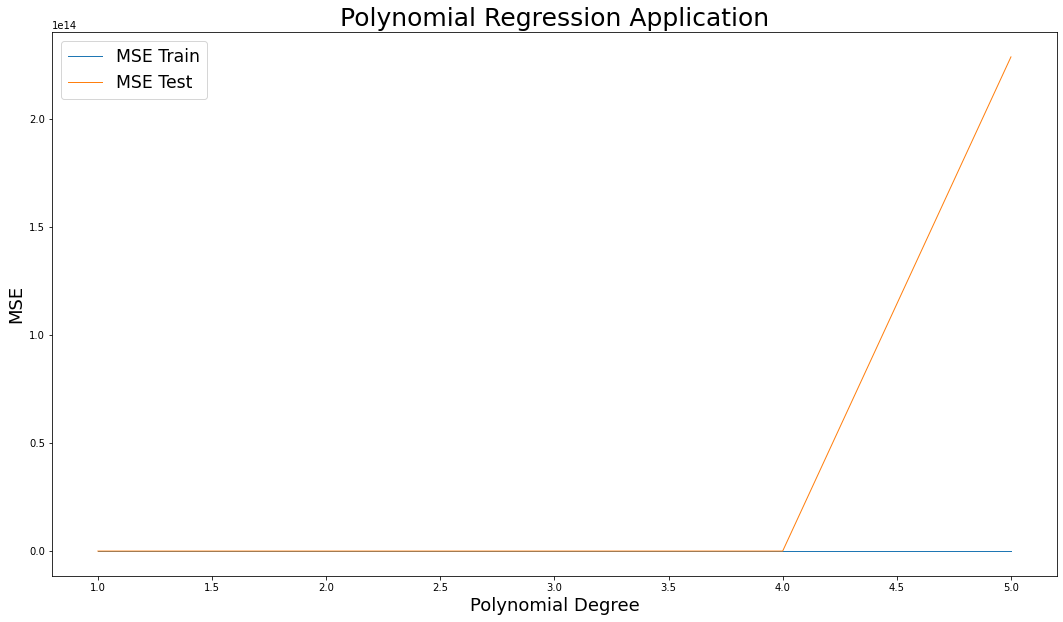

In [42]:
plt.plot(n_dict["Degree"], n_dict["mse_train"], label="MSE Train")
plt.plot(n_dict["Degree"], n_dict["mse_test"], label="MSE Test")
plt.legend(loc=2,fontsize="xx-large")
plt.xlabel("Polynomial Degree", fontsize=18)
plt.ylabel("MSE", fontsize=18)
plt.title( "Polynomial Regression Application", fontsize=25 )
plt.show()

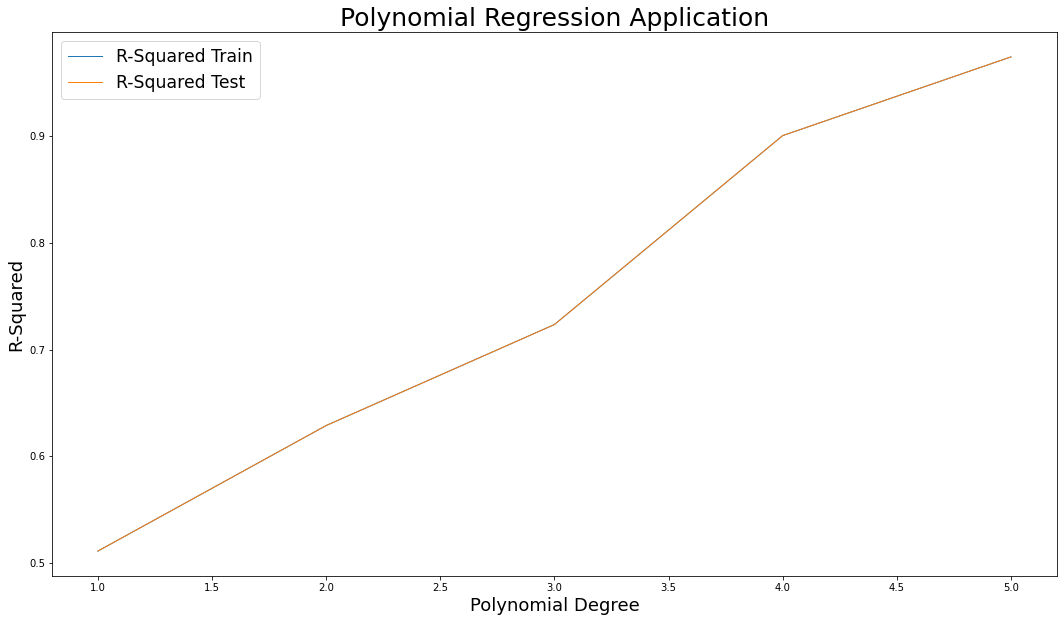

In [43]:
plt.plot(n_dict["Degree"], n_dict["Rsq_train"], label="R-Squared Train")
plt.plot(n_dict["Degree"], n_dict["Rsq_test"], label="R-Squared Test")
plt.legend(loc=2,fontsize="xx-large")
plt.xlabel("Polynomial Degree", fontsize=18)
plt.ylabel("R-Squared", fontsize=18)
plt.title( "Polynomial Regression Application", fontsize=25 )
plt.show()

## 6. Conclusion & Future Work

Prediction with polynomial regression application to complete time serie was the most accurate one along side the other experiments. Therefore model was created with 14. degree which is the best.

The model gave negative values in the prediction results, but the production value cannot be negative, so post processing was applied. In addition, the model was giving values that were too extreme to be true at some points, and they were scaled to 1.

/Users/han/Anaconda/anaconda3/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


Reg score:  0.896722525326711


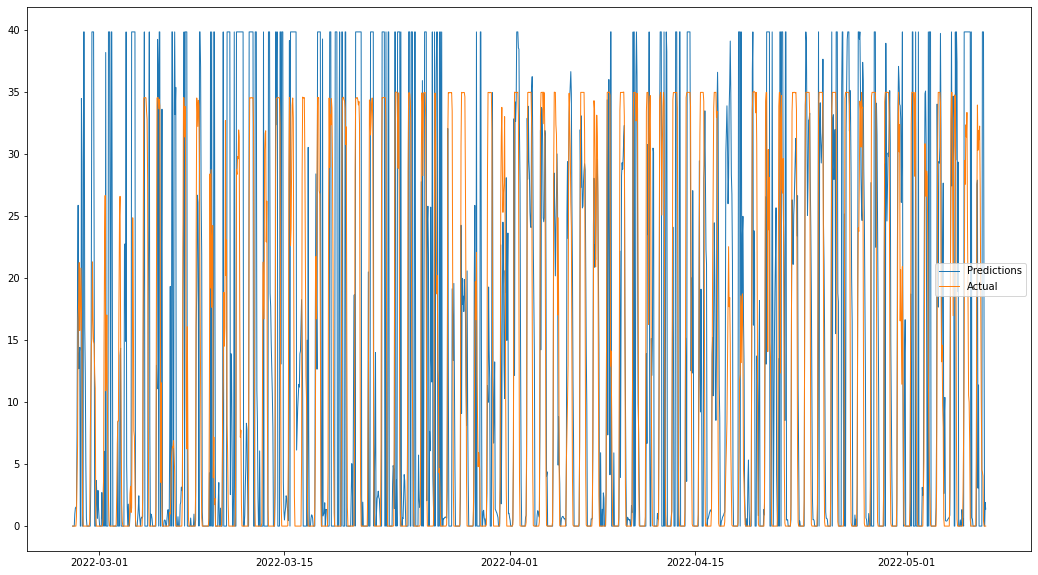

In [44]:
test_loc = data[data["TIME"].dt.date == pd.to_datetime("20220301", format="%Y%m%d")].index.values[0] - 2*24

x_train = np.asanyarray( scaled_data[scaled_data.columns.values[2:]][:test_loc] )
y_train = np.asanyarray( scaled_data["VOLUME"][:test_loc] )
x_test = np.asanyarray( scaled_data[scaled_data.columns.values[2:]][test_loc:] )
y_test = np.asanyarray( scaled_data["VOLUME"][test_loc:] )

poly = PolynomialFeatures(degree=14)
x_train_p = poly.fit_transform(x_train)
x_test_p = poly.fit_transform(x_test)
    
lr = linear_model.LinearRegression()
lr.fit( x_train_p, y_train )
train_pred = lr.predict( x_train_p )
test_pred = lr.predict( x_test_p )

#post processing
train_pred[train_pred < 0.01] = 0
train_pred[train_pred > 1] = 1
test_pred[test_pred < 0.01] = 0
test_pred[test_pred > 1] = 1

print("Reg score: ",lr.score( poly.fit_transform(x_train) , y_train ))

#converting estimates
test_pred = max_prod * test_pred
actual = data["VOLUME"][test_loc:].values

plt.plot(data[test_loc:]["TIME"].values,
        test_pred,
        label="Predictions")
plt.plot(data[test_loc:]["TIME"].values,
        actual,
        label="Actual")
plt.legend()



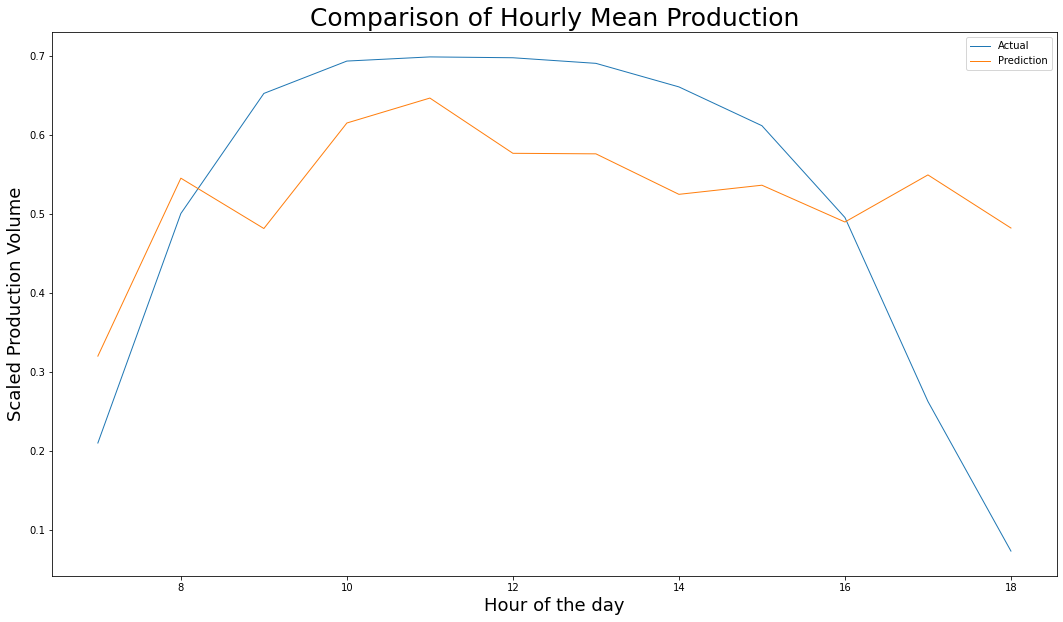

In [45]:
prediction_hourly_means = []
for i in range(0,len( prod_data.groupby([prod_data['TIME'].dt.hour]).mean().index.values )):
    prediction_hourly_means.append( np.mean( test_prediction[i:len(test_prediction):len(prod_times)+2] ) )

plt.plot(prod_data.groupby([prod_data['TIME'].dt.hour]).mean().index.values,
        prod_data.groupby([prod_data['TIME'].dt.hour]).mean()["VOLUME"],
        label="Actual")
plt.plot(prod_data.groupby([prod_data['TIME'].dt.hour]).mean().index.values,
        prediction_hourly_means,
        label="Prediction")

plt.xlabel( "Hour of the day", fontsize=18 )
plt.ylabel( "Scaled Production Volume", fontsize=18 )
plt.title( "Comparison of Hourly Mean Production", fontsize=25 )
plt.legend()
plt.show()

In [46]:
#first 100 individual predictions
(test_pred*max_prod)[:100]

array([   0.        ,    0.        ,    0.        ,    0.        ,
         38.95637463,   57.19665819,   61.11894101,   57.46967091,
        292.43959014,  772.52488482, 1032.4405835 ,  506.07508157,
        548.91077825,  575.08359824,    0.        ,    0.        ,
       1376.25460956, 1173.78533861,    0.        ,    0.        ,
       1590.4144    , 1590.4144    ,  640.36397446,  488.22914973,
        198.91453069,   24.93868789,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,  142.0217121 ,  915.57900294, 1590.4144    ,
       1590.4144    , 1590.4144    , 1590.4144    ,  959.64932384,
          0.        ,    0.        ,    0.        ,  146.96930939,
         92.80358458,   25.29057096,  114.69313825,   59.16841676,
         24.99935739,    0.        ,    0.        ,    0.        ,
          0.        ,  107.98309214,   25.92760065,    0.        ,
        138.89419965,    0.        ,  240.6066074 ,    0.     

#### Possible extensions to have a better approach:

* Significance test can be performed for the coefficients in the models and the unimportant ones can be set to 0.
* Lasso regression can be applied so that the model can decide and select important data for itself.
* Correlation-autocorrelations in the data can be removed and added to the model in that way.
* Separate models can be installed for each hour of the day.
* Regression with trend and seasonality can be used by creating a seasonal index according to the hours of the day.
* Inputs can be clustered and added to the model according to the season or other features.
* New features can be created with the data types we have. For example; Monthly mean, weekly std etc.